### Summary:
Probably not worth the effort of moving to the ensemble: the ringing is still there, and it seems to agree well with the HRES. 

In [3]:
import xarray as xr
import numpy as np
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from unified_traj_data import add_ERA_ens_to_trajectory
import utils
import lagrangian_case as lc
%load_ext autoreload
%autoreload 2

In [4]:
ens_dir = r'/home/disk/eos4/jkcm/Data/CSET/ERA5/ensemble'
ens_files = [os.path.join(ens_dir, i) for i in sorted(os.listdir(ens_dir))]
hres_data = xr.open_dataset(r'/home/disk/eos4/jkcm/Data/CSET/ERA5/proc/julaugmean.nc')
data = xr.open_mfdataset(ens_files)
data['dspdt'] = (data.sp.dims, np.gradient(data.sp, np.median(np.gradient(data.time.values)/np.timedelta64(1, 's')), axis=0),
                {'units': "Pa s**-1", 'long_name': "Surface pressure tendency", 'standard_name': 'tendency_of_surface_air_pressure'})
data['w_corr'] = (data.w.dims, data.w - data.dspdt, {'units': data.w.units, 'long_name': 'Vertical velocity (sp-corrected)'})

ens_mean = data.mean(dim='number', keep_attrs=True)
time_mean = ens_mean.mean(dim='time', keep_attrs=True)

plt_ensmean = time_mean.w_corr.sel(level=700)
plt_ens1 = data.mean(dim='time').w_corr.sel(level=700, number=1)
plt_hres = hres_data.w.sel(level=700).isel(time=0)

In [6]:
ds = xr.open_dataset('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf06_72h_forward_2.3.nc')
box_degrees=2
data



if True:
    if True:
#         data = data.rename({'level': 'ens_level'})
#         ds.coords['number'] = data.coords['number']
#         ds.coords['ens_level'] = data.coords['ens_level']
#         lats, lons, times = ds.lat.values, ds.lon.values, ds.time.values
#         space_index = int(np.round(box_degrees/0.3/2)) # go up/down/left/right this many pixels


        for var in data.data_vars.keys():
            var_shape = data[var].isel(time=0, latitude=0, longitude=0).shape
            vals = []
            for (lat, lon, time) in zip(lats, lons%360, times):
                if lat > np.max(data.coords['latitude']) or lat < np.min(data.coords['latitude']) or \
                    lon > np.max(data.coords['longitude']) or lon < np.min(data.coords['longitude']):
                    print('out of range of data')
                    print(lat, lon, time)
                    vals.append(np.full(var_shape, float('nan'), dtype='float'))
#                     continue
                x = data[var].sel(longitude=slice(lon - box_degrees/2, lon + box_degrees/2),
                                  latitude=slice(lat + box_degrees/2, lat - box_degrees/2))
                z = x.sel(method='nearest', time=time, tolerance=np.timedelta64(1, 'h'))
                #this applies a 2D gaussian the width of z, i.e. sigma=box_degrees
                gauss_shape = tuple([v for v,i in zip(z.shape,z.dims) if i in ['latitude', 'longitude'] ])
                gauss = utils.gauss2D(shape=gauss_shape, sigma=gauss_shape[-1])
                filtered = z * gauss
                filtered2 = z.values * gauss
                vals.append(filtered.sum(dim=('latitude', 'longitude').values))
            ds['ERA_ens_'+var] = (('time', 'number', 'ens_level'), np.array(vals), data.w.attrs)

FileNotFoundError: [Errno 2] No such file or directory: b'/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf06_all_traj_2.3.nc'

Text(0.5,1.02,'July/August 2015 NE Pacific subsidence, 2-month mean')

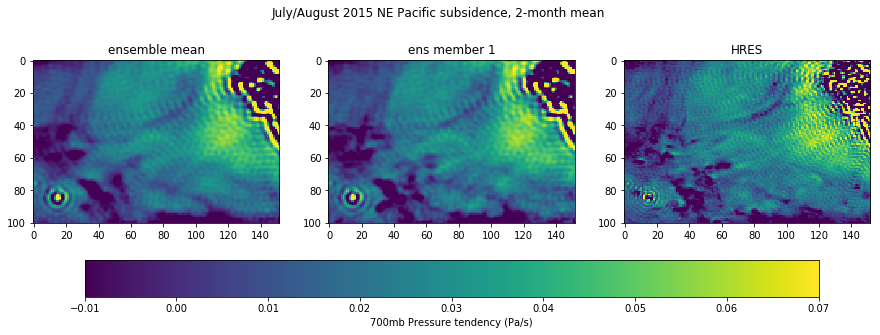

In [79]:
fig, [ax1, ax2, ax3] = plt.subplots(ncols=3, figsize=(15, 4.5))
vmin, vmax = -0.01, 0.07
im1 = ax1.imshow(plt_ensmean, vmin=vmin, vmax=vmax)
ax1.set_title("ensemble mean")
im2 = ax2.imshow(plt_ens1, vmin=vmin, vmax=vmax)
ax2.set_title("ens member 1")
im3 = ax3.imshow(plt_hres, vmin=vmin, vmax=vmax)
ax3.set_title("HRES")
cb = plt.colorbar(im3, ax=[ax1, ax2, ax3], orientation='horizontal')
cb.set_label("700mb Pressure tendency (Pa/s)")
plt.suptitle("July/August 2015 NE Pacific subsidence, 2-month mean", y=1.02)


In [95]:
fig.savefig(os.path.join(utils.plot_dir,"subsidence_ringing.png"), dpi=300)

In [9]:
def add_w_corr_to_data(data):
    data['ERA_dspdt'] = (data.ERA_sp.dims, np.gradient(data.ERA_sp, np.median(np.gradient(data.time.values)/np.timedelta64(1, 's')), axis=0),
                    {'units': "Pa s**-1", 'long_name': "Surface pressure tendency", 'standard_name': 'tendency_of_surface_air_pressure'})
    data['ERA_w_corr'] = (data.ERA_w.dims, data.ERA_w - data.ERA_dspdt, {'units': data.ERA_w.units, 'long_name': 'Vertical velocity (sp-corrected)'})
        

data_RF06 = xr.open_dataset('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf06_72h_forward_2.3.nc')
data_RF06 = add_ERA_ens_to_trajectory(data_RF06)
add_w_corr_to_data(data_RF06)


        
data_RF10 = xr.open_dataset('/home/disk/eos4/jkcm/Data/CSET/Lagrangian_project/trajectory_files/rf10_72h_forward_6.0.nc')
data_RF10 = add_ERA_ens_to_trajectory(data_RF10)
add_w_corr_to_data(data_RF10)

In [27]:
data_RF06.ERA_ens_w.sel(ens_level=700, number=1).shape

(73,)

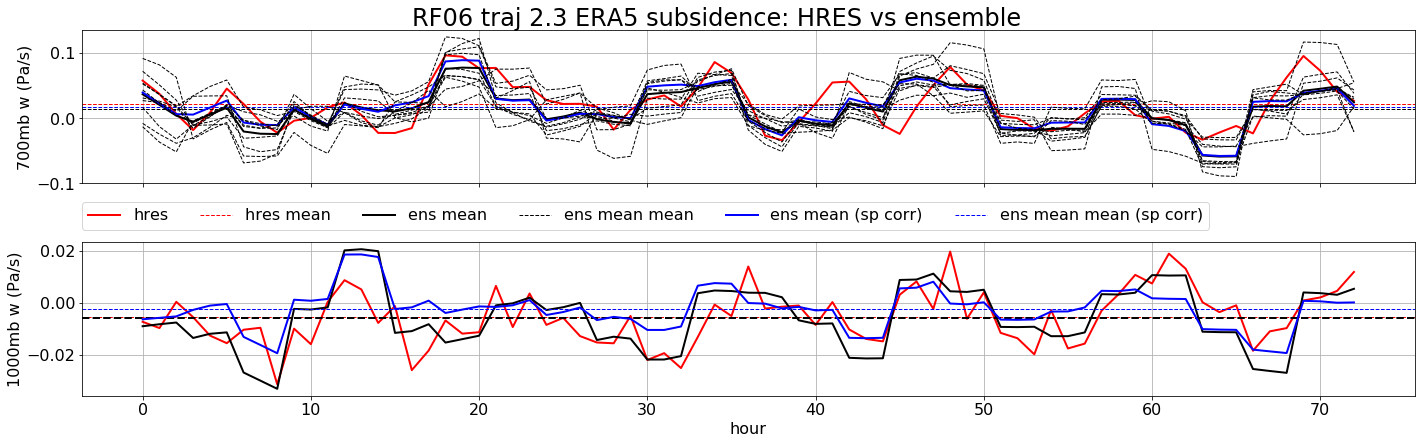

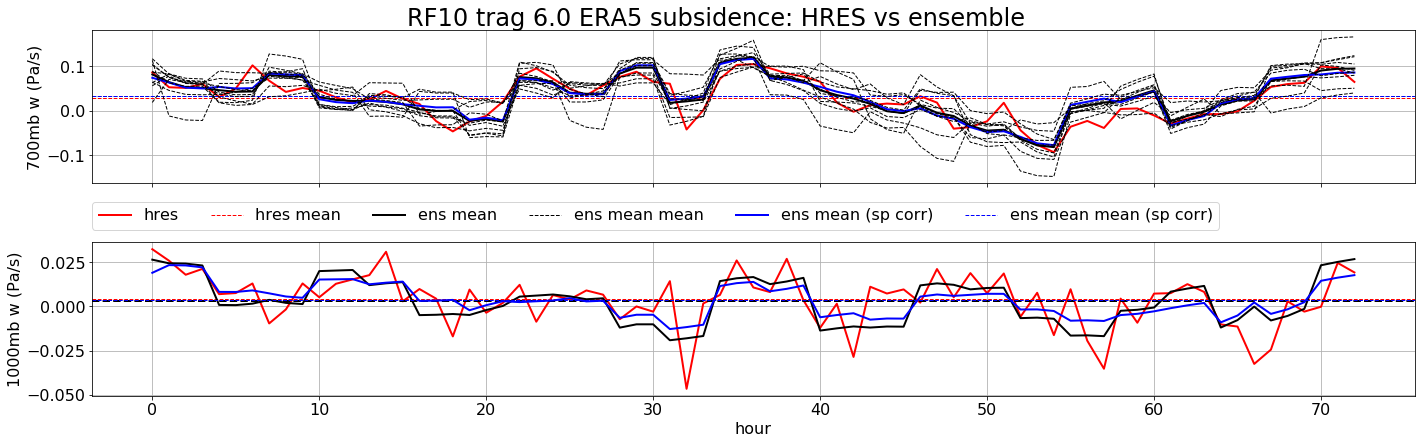

In [34]:
for name,data in {"RF06 traj 2.3": data_RF06,
                  "RF10 trag 6.0": data_RF10}.items():

    fig, [ax1, ax2] = plt.subplots(nrows=2, sharex=True, figsize=(20,6))
#     for i in data.number:
#         p1 = ax1.plot(data.ERA_ens_w.sel(ens_level=700, number=i), alpha=0.5, label=i.values)
#         p2 = ax2.plot(data.ERA_ens_w.sel(ens_level=1000, number=i), alpha=0.5, label=i.values, c=p1[0].get_color())

    hres_mean = np.nanmean(data.ERA_w.sel(level=700))
    ax1.plot(data.ERA_w.sel(level=700), c='r', lw=2,  label='hres')
    ax1.axhline(hres_mean, c='r', lw=1, ls='--', label='hres mean')

    ensmean_mean = np.nanmean(data.mean(dim='number').ERA_ens_w.sel(ens_level=700))
    ax1.plot(data.mean(dim='number').ERA_ens_w.sel(ens_level=700), lw=2, c='k', label='ens mean')
    ax1.axhline(ensmean_mean, c='k', lw=1, ls='--', label='ens mean mean')
    
    ensmean_mean_corr = np.nanmean(data.mean(dim='number').ERA_ens_w_corr.sel(ens_level=700))
    ax1.plot(data.mean(dim='number').ERA_ens_w_corr.sel(ens_level=700), lw=2, c='b', label='ens mean (sp corr)')
    ax1.axhline(ensmean_mean_corr, c='b', lw=1, ls='--', label='ens mean mean (sp corr)')

    for mem in data.number.values:
        ax1.plot(data.ERA_ens_w.sel(ens_level=700, number=mem), '--', lw=1, c='k', label='')

    
    
    
    
    hres_mean_sfc = np.nanmean(data.ERA_w.sel(level=1000))
    ax2.plot(data.ERA_w.sel(level=1000), label='hres', c='r', lw=2)
    ax2.axhline(hres_mean_sfc, c='r', lw=1, ls='--', label='hres mean')

    ensmean_mean_sfc = np.nanmean(data.mean(dim='number').ERA_ens_w.sel(ens_level=1000))
    ax2.plot(data.mean(dim='number').ERA_ens_w.sel(ens_level=1000), lw=2, c='k', label='ens mean')
    ax2.axhline(ensmean_mean_sfc, c='k', lw=2, ls='--', label='ens mean mean')
    
    ensmean_mean_corr = np.nanmean(data.mean(dim='number').ERA_ens_w_corr.sel(ens_level=1000))
    ax2.plot(data.mean(dim='number').ERA_ens_w_corr.sel(ens_level=1000), lw=2, c='b', label='ens mean (sp corr)')
    ax2.axhline(ensmean_mean_corr, c='b', lw=1, ls='--', label='ens mean mean (sp corr)')

    ax1.legend(ncol=7, loc=(0.0, -0.3))
    ax1.set_ylabel("700mb w (Pa/s)")
    ax2.set_ylabel("1000mb w (Pa/s)")
    ax2.set_xlabel('hour')
    fig.tight_layout()
    plt.suptitle("{} ERA5 subsidence: HRES vs ensemble".format(name),y=1.02)
    ax1.grid(True)
    ax2.grid(True)

In [20]:
hres_mean

NameError: name 'hres_mean' is not defined

In [4]:
combined_cases = {}
for key, case in lc.all_cases.items():
    if key not in [6]:#, 10]:
        continue
# case = lc.all_cases[1]
    print(key)
    TLC = lc.TrajectoryCase(case['TLC_name'])
    TLC.add_traj_data()
    ALC = lc.AircraftCase(case['ALC_name'])
#     ALC.add_ERA_data()
    ALC.add_precip_data()
    CLC = lc.CombinedCase(ALC, TLC, number=key)
    combined_cases[key] = CLC
#     CLC.plot(save=True)

6
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert
adding ERA ens w_vert


In [13]:
#estimate subsidence uncertainty for a case:
TLC = combined_cases[6].TLC

era_ens_w = TLC.get_from_inv('ERA_ens_w_vert', ens=True)

# for k,v in TLC.traj_data.items():
    
#     era_ens_w = get_from_inv('ERA_ens_w_vert').items()
    
    
    
    
    
#         for k,v in case.TLC.get_from_inv('ERA_w_vert').items():
#         index = np.logical_and(case.TLC.traj_data[k].time > df['out_time'][num], case.TLC.traj_data[k].time < df['ret_time'][num])
#         subs_vals.append(np.nanmean(v[index]))
#     df['subs'][num] = np.nanmean(subs_vals)*1000
    

(73, 10)
(73, 10)
(73, 10)
(73, 10)
(73, 10)
(73, 10)
(73, 10)
(73, 10)
(73, 10)
(73, 10)


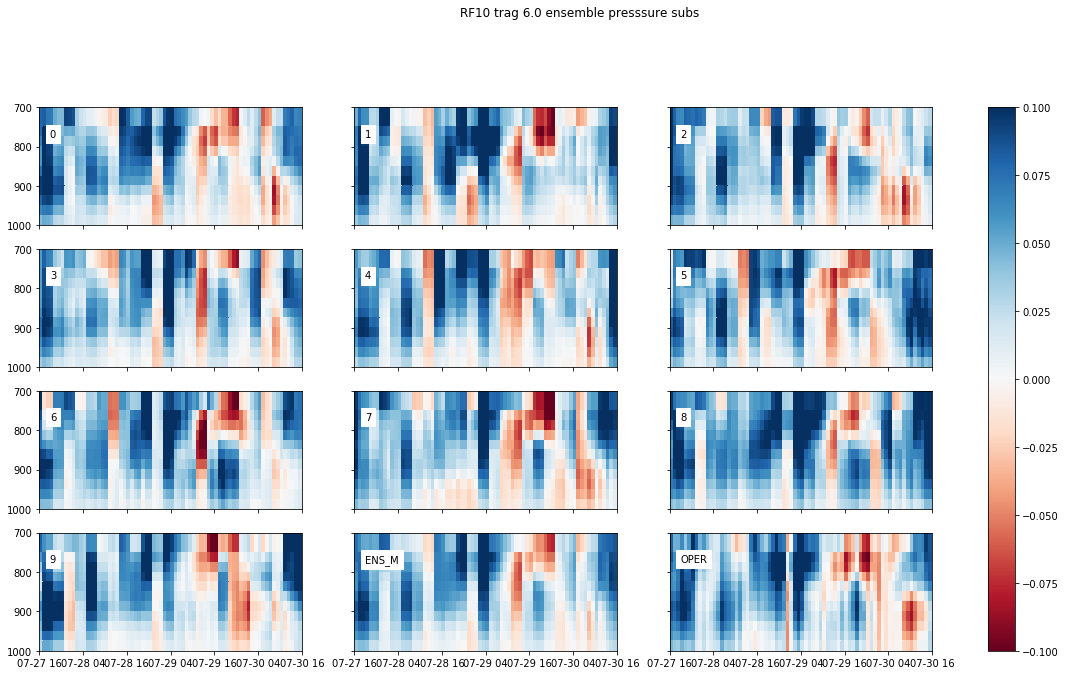

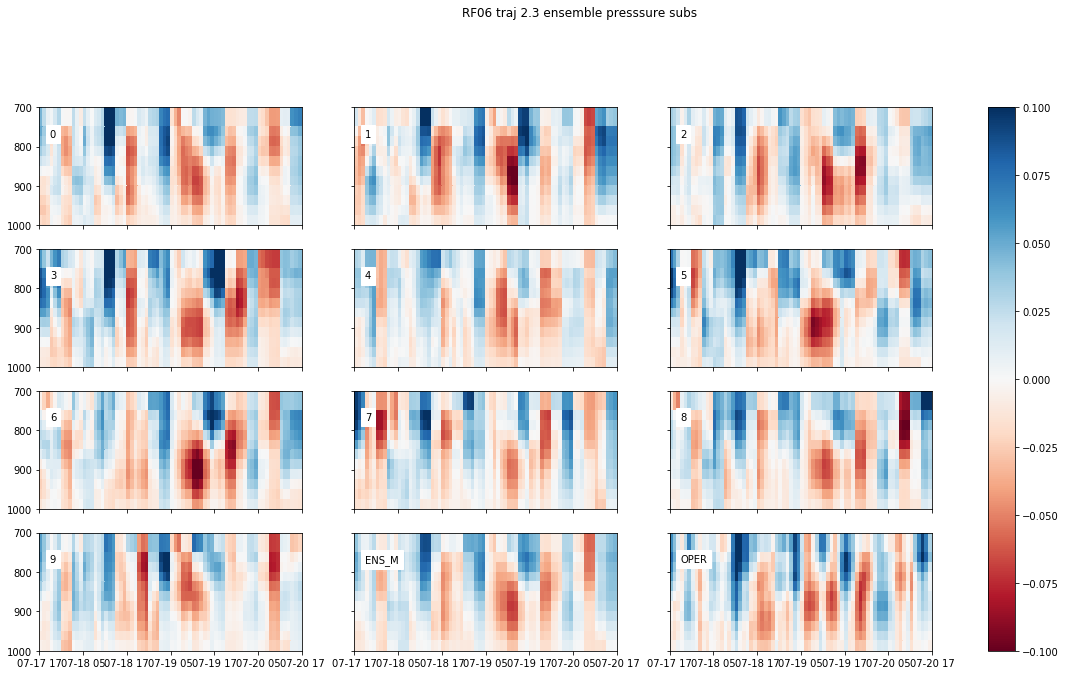

In [304]:
# vertical structure of w:
# vmin, vmax=-0.005, 0.005
vmin, vmax=-0.1, 0.1
for name,data in {"RF06 traj 2.3": data_RF06,
                  "RF10 trag 6.0": data_RF10}.items():

    fig, ax_arr = plt.subplots(figsize=(20,10), nrows=4, ncols=3, sharex=True, sharey=True)
    ax = ax_arr.flatten()
    for i in data.number.values:
        x = data.ERA_ens_w_corr.sel(number=i).values
#         x = np.gradient(x)[1]
        pc = ax[i].pcolormesh(np.broadcast_to(data.time.values[None,:], x.T.shape), np.broadcast_to(data.ens_level.values[:,None], x.T.shape),  x.T, cmap='RdBu', vmin=vmin, vmax=vmax)
        ax[i].annotate(str(i), xy=(0.04, 0.75), xycoords='axes fraction', color='k', backgroundcolor='w')

    ax[0].invert_yaxis()

    
    x = data.ERA_ens_w_corr.mean(dim='number')
#     x = np.gradient(x)[1]
    ax[10].pcolormesh(np.broadcast_to(data.time.values[None,:], x.T.shape), np.broadcast_to(data.ens_level.values[:,None], x.T.shape),  x.T, cmap='RdBu', vmin=vmin, vmax=vmax)
    ax[10].annotate('ENS_M', xy=(0.04, 0.75), xycoords='axes fraction', color='k', backgroundcolor='w')

    
    x = data.ERA_w_corr.values
#     x = np.gradient(x)[1]
    ax[11].pcolormesh(np.broadcast_to(data.time.values[None,:], x.T.shape), np.broadcast_to(data.level.values[:,None], x.T.shape),  x.T, cmap='RdBu', vmin=vmin, vmax=vmax)
    ax[11].annotate('OPER', xy=(0.04, 0.75), xycoords='axes fraction', color='k', backgroundcolor='w')
    
    ax[11].set_ylim(1000,700)
    
    plt.colorbar(pc, ax=ax)
#     ax1.set_ylabel("700mb omega (Pa/s)")
#     ax2.set_ylabel("1000mb omega (Pa/s)")
#     ax2.set_xlabel('hour')
    fig.suptitle("{} ensemble presssure subs".format(name),y=1.02)
        